In [1]:
import numpy as np
import json
from datatypes.vessel import Vessel
from datatypes.track import Track
from dynamicSceneGenerator import DynamicSceneGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera

from visualize import visualize_dynamic_scene_mov, visualize_camera_pose_in_dsg_mov, visualize_projections_mov, visualize_bounding_boxes_mov, visualize_distorted_bounding_boxes_mov
from MODSIM import create_and_place_simple_legacy_camera, project_all_points, create_all_bbs, tracks_to_json, vessels_to_json, project_all_points_from_json, create_all_bbs_from_json
from errorGenerator import ErrorGenerator



In [2]:
vehicle_characteristics_path = 'boats_in_fishtank/vehicle_characteristics.json'
dynamics_path = 'boats_in_fishtank/dynamics.json'
simulation_folder = './boats_in_fishtank/simulation/'

In [3]:
# Get vessels
with open(vehicle_characteristics_path, 'r') as f:
    vessel_dict = json.load(f)

# air_draft: int = 2, beam: int = 2, length: int = 4, label: str = "")
vessels = [Vessel(vesselID, length=vessel['length_m'], beam=vessel['width_m'], label=vessel['type']) for vesselID, vessel in vessel_dict.items()]

In [4]:
# Create dynamic scene with vessels

dsg = DynamicSceneGenerator(vessels)

In [5]:
# Load tracks 
with open(dynamics_path, 'r') as f:
    dynamics = json.load(f)

tracks = {vessel.id: Track() for vessel in vessels}

for t, positions in dynamics['time_s'].items():
    for vesselID, position in positions.items():
        x = position['center_position_m'][0]
        y = position['center_position_m'][1]
        z = 0
        heading_rad = position['heading_rad'] 
        time_stamp = float(t)
        tracks[vesselID].addPosition(x, y, z, heading_rad, time_stamp)

In [6]:
# Update each vessel in the scene with the correct track
for vessel in dsg.get_vessels():
    vessel.set_track(tracks[vessel.id])

In [7]:
vessels = dsg.get_vessels()

In [8]:
#tracks_to_json(vessels, simulation_folder)
#vessels_to_json(vessels, simulation_folder)

Moviepy - Building video ./boats_in_fishtank/simulation/dynamicScene.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/dynamicScene.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/dynamicScene.mp4


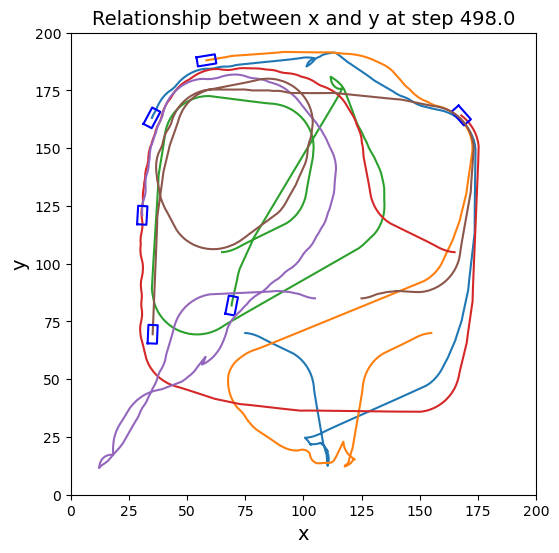

In [9]:
visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder, fps=1, skip=10, max_time_steps=5000, y_x_lim=200) 

In [10]:
# Static camera
largest_radius = 100
path_centre = (100,100)
height = 60
camera = create_and_place_simple_legacy_camera(largest_radius, path_centre, height=height)

In [10]:
# Dynamic camera
focal_length = 50*10**-3
image_bounds = (3600, 2400) # Pixels (x,y)
film_size = (36*10**-3, 24*10**-3)
px = film_size[0]/image_bounds[0]
py = film_size[1]/image_bounds[1]
principal_point = (image_bounds[0]/2,image_bounds[1]/2)
width_of_sensor = 36*10**-3 # Width of sensor
roll_vcf = 0
yaw_vcf = 0
pitch_vcf = np.pi / 20
pos_vcf = np.array([vessels[0].get_length()/2, 0, vessels[0].get_air_draft()/2])

camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
camera_rig = CameraRig(camera, vessels[0])

Moviepy - Building video ./boats_in_fishtank/simulation/camera_position.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/camera_position.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/camera_position.mp4


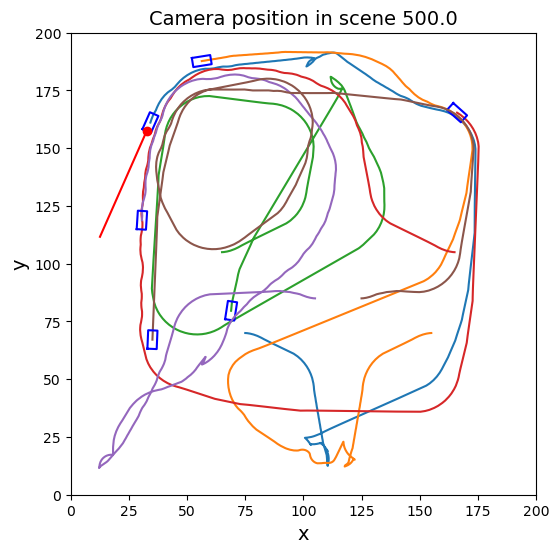

In [11]:
visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, fps=3, skip=10, max_time_steps=5000, y_x_lim=200)

In [13]:
# all_projected_points = project_all_points(camera, vessels, writeToJson=True, folder_path=simulation_folder)
all_projected_points = project_all_points_from_json(camera_rig, simulation_folder, writeToJson=True)


Moviepy - Building video ./boats_in_fishtank/simulation/projected_points.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/projected_points.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/projected_points.mp4


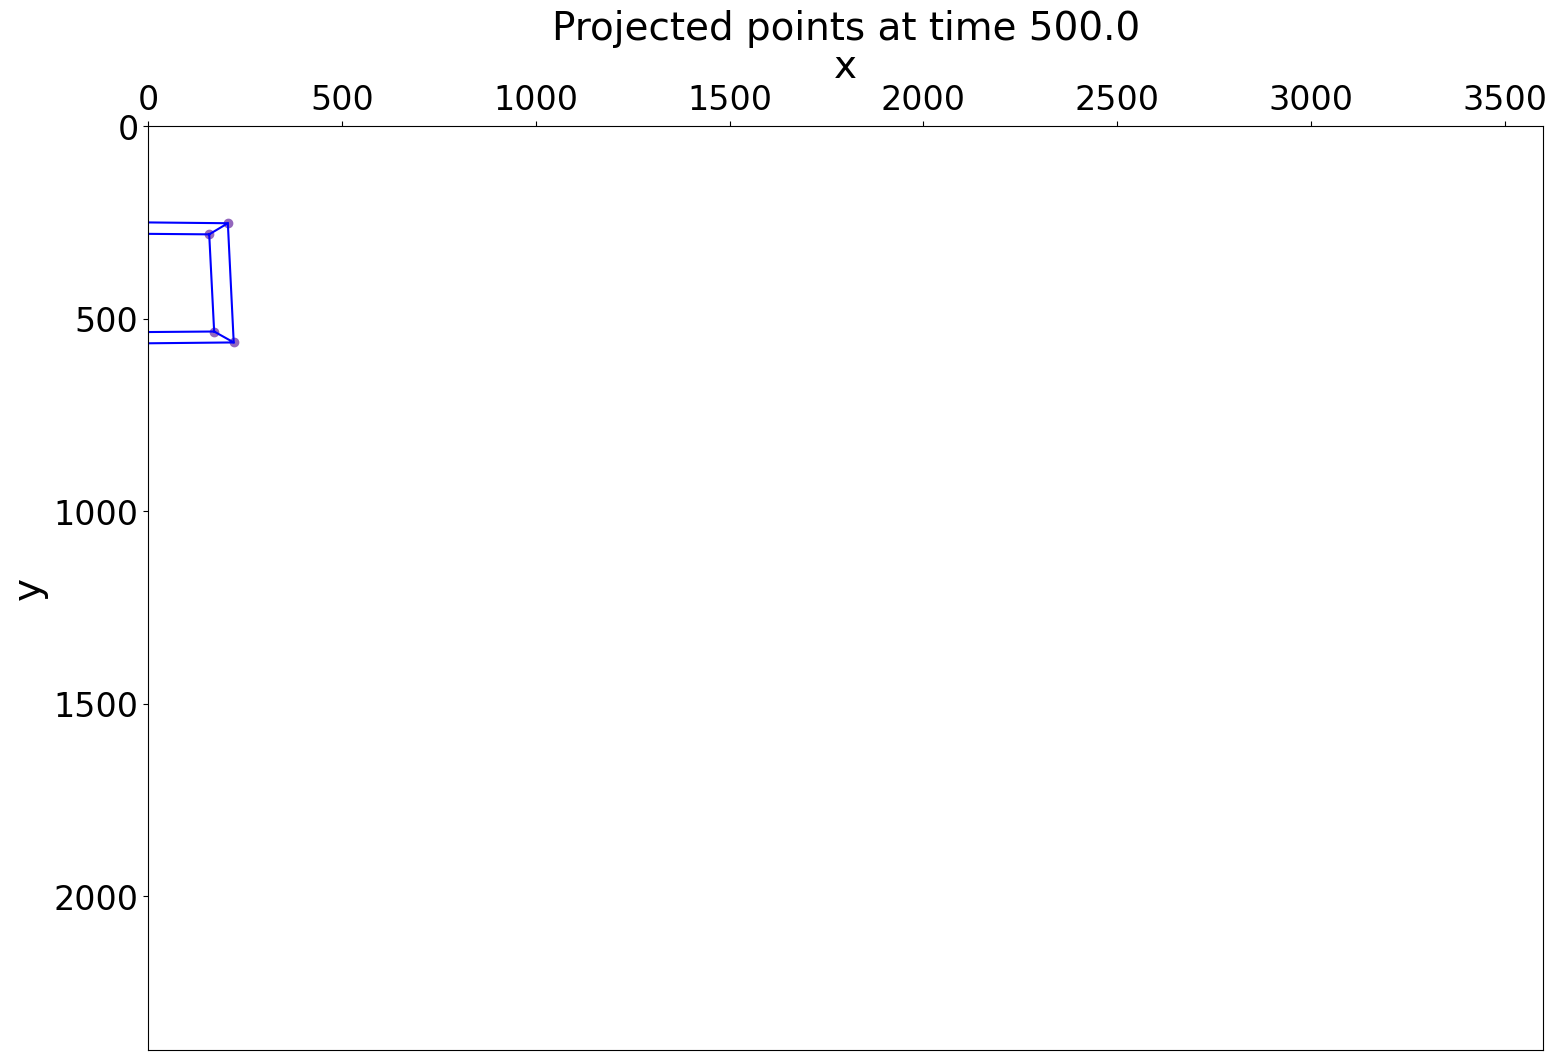

In [14]:
visualize_projections_mov(all_projected_points, camera.image_bounds, folder_path=simulation_folder, fps=3, skip=10, max_time_steps=5000)


In [19]:
# all_bbs=create_all_bbs(all_projected_points, writeToJson=True, folder_path=simulation_folder)
#annotation_mode = 1 : Only remove fully covered, annotation_mode=2: Cut partially covered boxes, everything else: no occlusion
all_bbs = create_all_bbs_from_json(simulation_folder, camera.image_bounds, annotation_mode=1, writeToJson=True)


Moviepy - Building video ./boats_in_fishtank/simulation/boundingBoxes.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/boundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/boundingBoxes.mp4


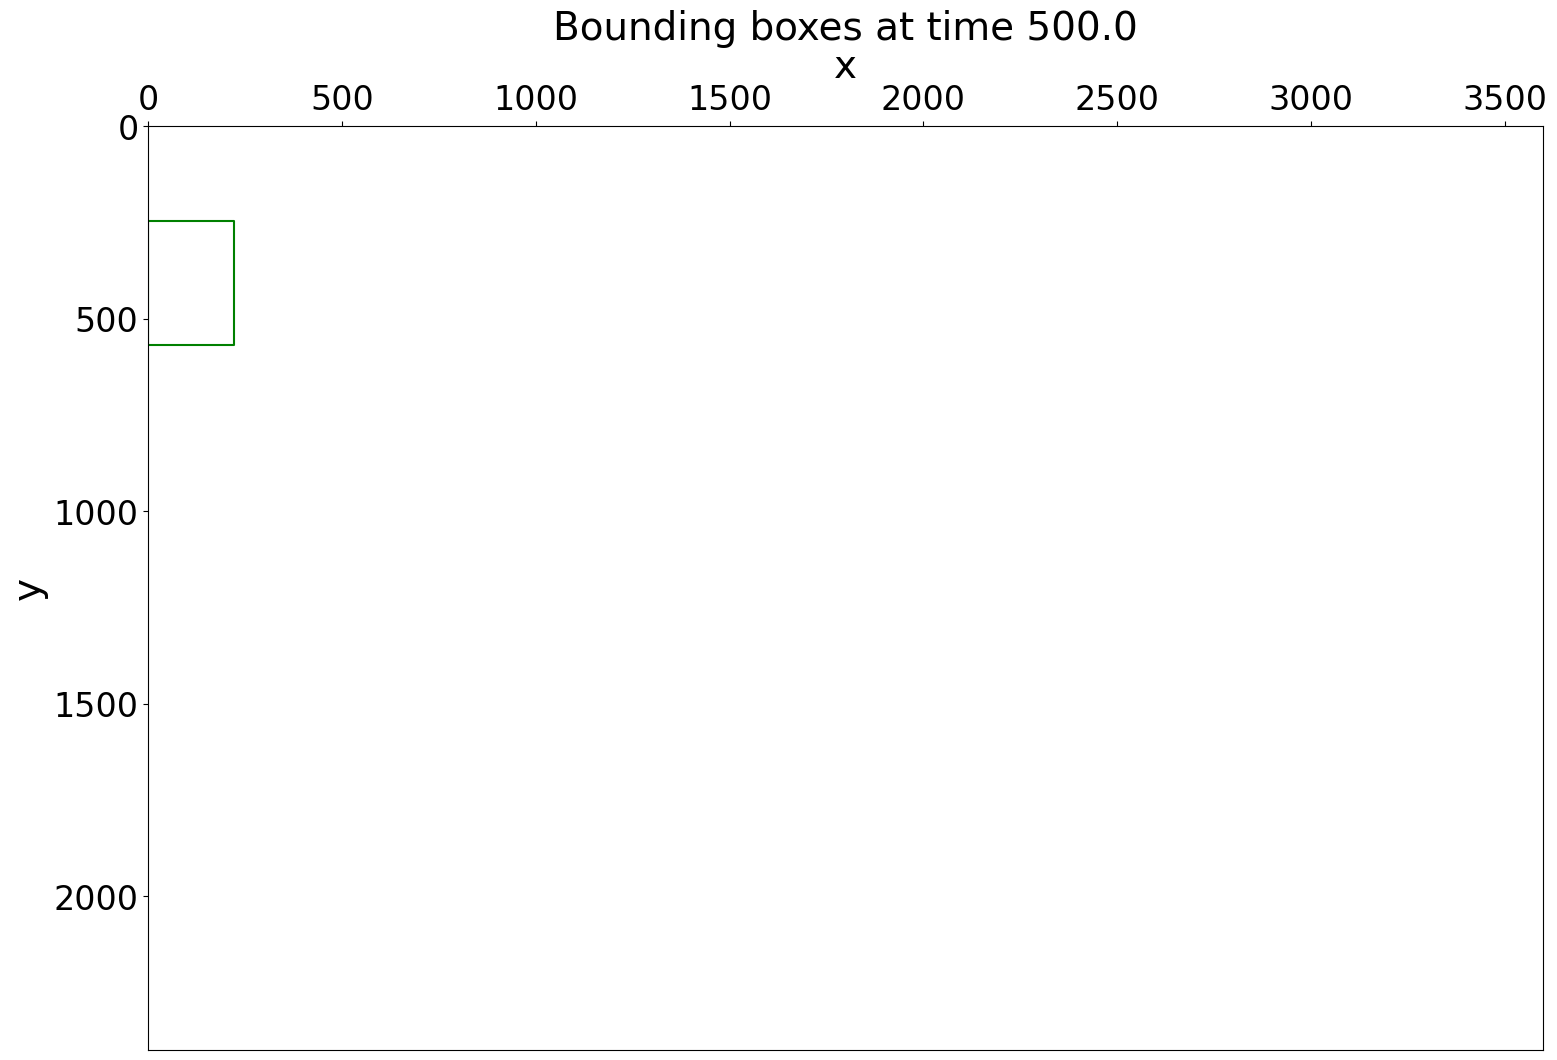

In [20]:
visualize_bounding_boxes_mov(all_bbs, camera.image_bounds, folder_path=simulation_folder, fps=3, skip=10, max_time_steps=5000)


In [21]:
path = 'detector_stats_config.yaml'
errorGenerator = ErrorGenerator(path)
errorBBs = errorGenerator.generate_all_error_BBs(all_bbs)

Moviepy - Building video ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4


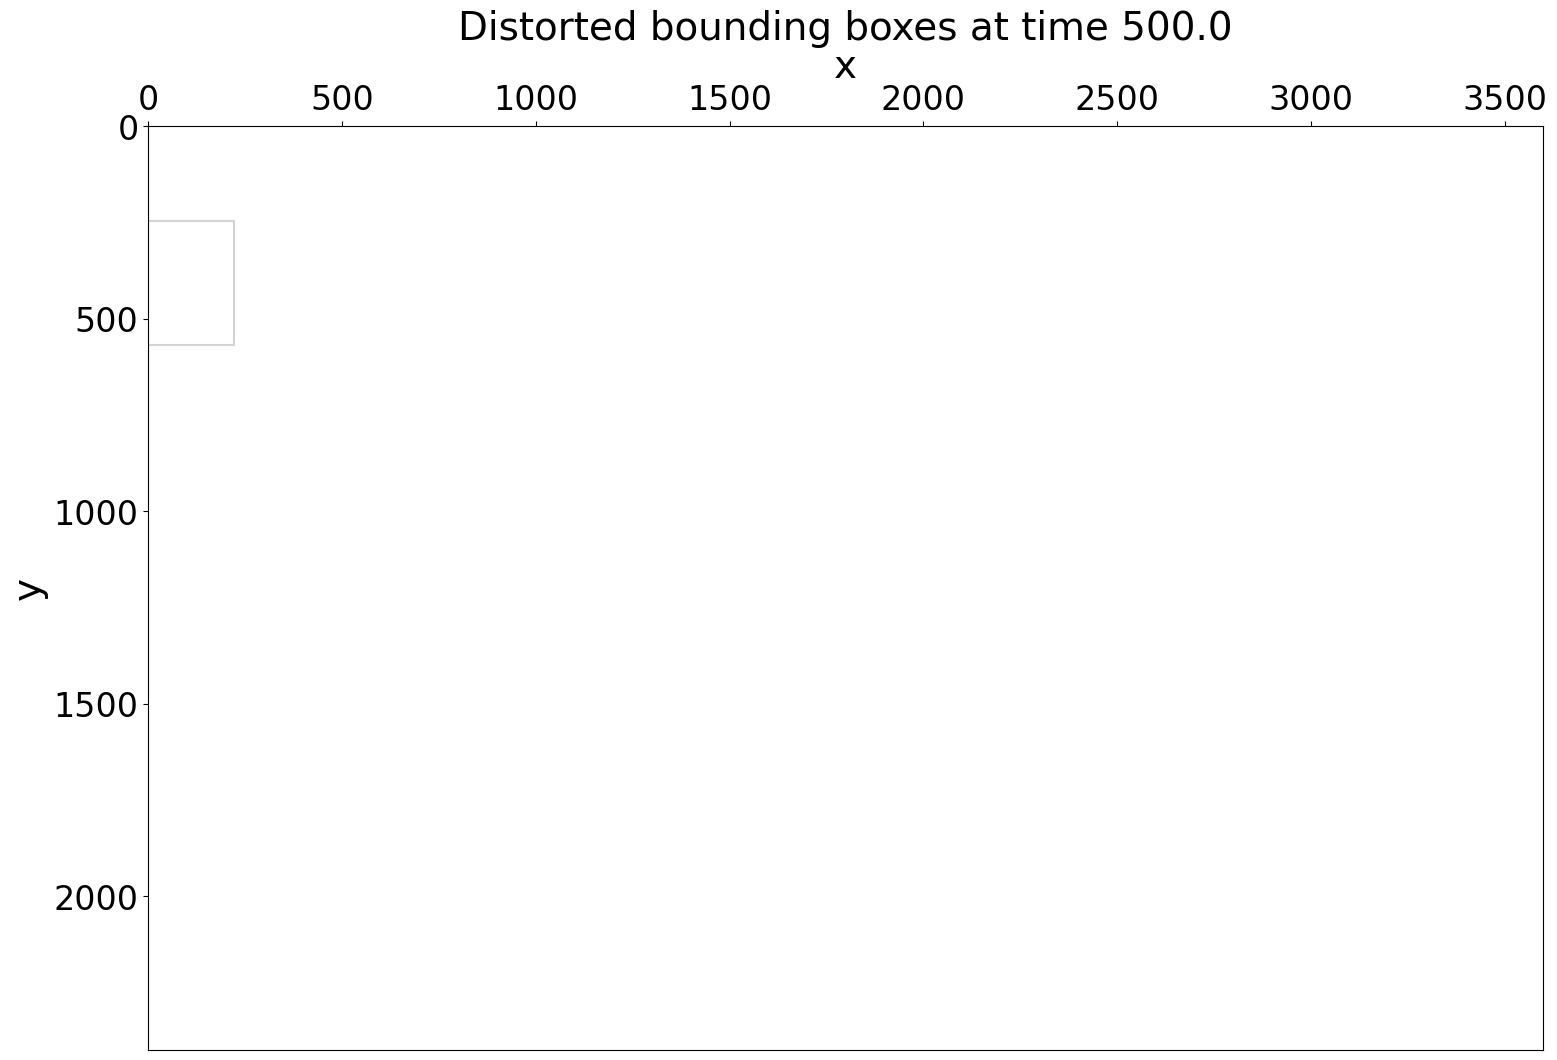

In [22]:
visualize_distorted_bounding_boxes_mov(errorBBs, camera.image_bounds, show_original_BBS=True, original_BBs=all_bbs, folder_path=simulation_folder, fps=3, skip=10, max_time_steps=5000)
